In [1]:
! apt-get -y update
! apt-get -y install unzip wget git

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease 
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:5 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [898 kB]
Fetched 1150 kB in 1s (1362 kB/s)                          
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
git is already the newest version (1:2.17.1-1ubuntu0.7).
wget is already the newest version (1.19.4-1ubuntu2.2).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [2]:
! wget https://www.dropbox.com/s/zzrsxojedhc0wff/dataset.zip?dl=1

--2020-09-14 17:24:53--  https://www.dropbox.com/s/zzrsxojedhc0wff/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.1, 2620:100:6028:1::a27d:4701
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zzrsxojedhc0wff/dataset.zip [following]
--2020-09-14 17:24:53--  https://www.dropbox.com/s/dl/zzrsxojedhc0wff/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0bbff508571c8ecce0a55a9e3.dl.dropboxusercontent.com/cd/0/get/A_ZahcXp2PEpD54SmSubpGcnGF2tI4ETIr9LFOQJKTZ3pGQD_AQi0Ty2KICQq-dh4EtMotf9ssUjx23vlb-1nkY0fe7gHKzFaT3xeuYpoXHRsQB6k5JnfgRSQRYW7hqB4JE/file?dl=1# [following]
--2020-09-14 17:24:53--  https://ucd0bbff508571c8ecce0a55a9e3.dl.dropboxusercontent.com/cd/0/get/A_ZahcXp2PEpD54SmSubpGcnGF2tI4ETIr9LFOQJKTZ3pGQD_AQi0Ty2KICQq-dh4EtMotf9ssUjx23vlb-1nkY0fe7gHKzFaT3xeuYpoXHRsQB6

In [3]:
#! unzip dataset.zip

In [4]:
! ls -alh dataset | wc -l

2631


In [5]:
! pip install git+git://github.com/ternaus/TernausNet.git#egg=ternausnet

In [6]:
# help(ternausnet.models.UNet11)

In [7]:
# ! pip install scikit-learn

In [8]:
! pip install matplotlib

In [9]:
! pip install tqdm

In [10]:
! pip install Pillow

In [11]:
import os
import json

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

from torch.optim import Adam
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from livelossplot import PlotLosses

import ternausnet.models
model = ternausnet.models.UNet11(pretrained=True)

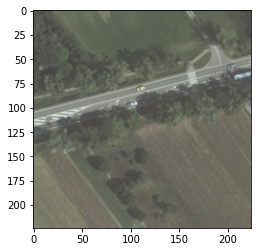

In [12]:
I = np.asarray(Image.open('dataset/20.png'))
plt.imshow(I[:, :, :3])

In [13]:
list_dataset = os.listdir('dataset')
number_files = len(list_dataset)
print(number_files)

2628


In [14]:
train_img_list, test_img_list = train_test_split(list_dataset, test_size=0.15)

In [15]:
with open('train_img_list.json', 'w') as f:
    json.dump(train_img_list, f)
    
with open('test_img_list.json', 'w') as f:
    json.dump(test_img_list, f)

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
def viz(model, i, device):
    I = np.asarray(Image.open(f'dataset/{i}.png'))
    II = I[:, :, :3].copy()
    I = torch.tensor(I, dtype=torch.float)
    I = I / 255
    I = I.transpose(1, 2).transpose(0, 1)
    im = I[:3, :, :]
    
    im = (im - torch.tensor([0.485, 0.456, 0.406])[..., None, None]) / torch.tensor([0.229, 0.224, 0.225])[..., None, None]
    
    gt = (I[3, :, :] * 255).numpy()
    im = im[None, ...]
    im = im.to(device)
    
    pred = model(im).detach().cpu().numpy()[0, 0]
    mask_pred = (pred > 0.5)
    
    gt = gt > 0.5
    
    print(mask_pred.sum())
    print(II.shape, mask_pred.shape)
    II[:, :, 0][mask_pred] = 255
    II[:, :, 1][gt] = 255
    return II
    

In [18]:
# res = viz(model, 100, 'cuda:0')
# plt.imshow(res)

In [19]:
class WaterDataset(Dataset):
    def __init__(self, image_folder, file_path, transform=None):
        super().__init__()
        with open(file_path, 'r') as f:
            self.image_list = json.load(f)       
        self.image_folder = image_folder
        self.transforms = transform
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406, 0],
                                std=[0.229, 0.224, 0.225, 1])
        ])
        
    def __len__(self):
        # return 100
        return len(self.image_list)
        # len([name for name in os.listdir(self.image_folder) if name.endswith('.png') ])
        
    def __getitem__(self, idx):
        #idx = idx + 1
        file_name = self.image_list[idx]
        
        I = Image.open(f'{self.image_folder}/{file_name}') # h x w x 4
        if self.transforms is not None:
            I = self.transforms(I) # h x w x 4
        I = self.to_tensor(I)
        im = I[:3, :, :]
        gt = I[[-1], :, :] * 255
        return im, gt

In [20]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(90, resample=False, expand=False, center=None, fill=None),
])

d_train = WaterDataset('dataset', 'train_img_list.json', transform)
d_val = WaterDataset('dataset', 'test_img_list.json', None)

In [21]:
pred = np.random.random(6).reshape(3,2)
gt = np.random.randint(0, 2, size=6).reshape(3,2)

pred, gt

threshold = 0.5

pred, gt, (pred > threshold) != gt.astype(np.bool), ((pred > threshold) != gt.astype(np.bool)).sum()

((gt == 1) & (pred > threshold)).sum() / (gt == 1).sum()

0.5

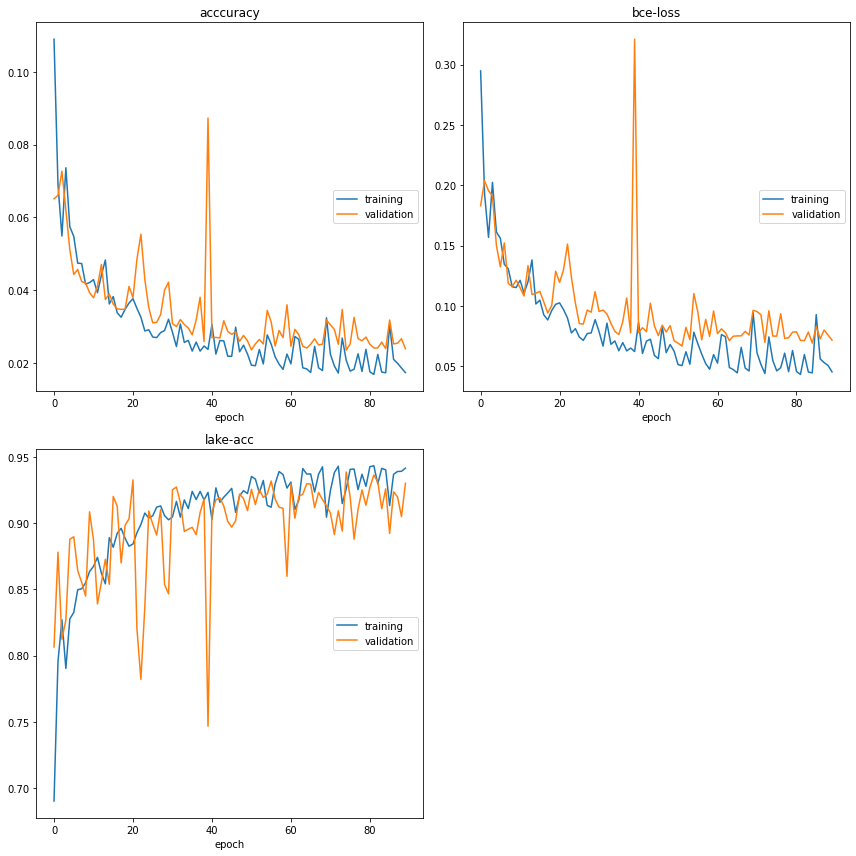

acccuracy
	training         	 (min:    0.017, max:    0.109, cur:    0.017)
	validation       	 (min:    0.023, max:    0.087, cur:    0.024)
bce-loss
	training         	 (min:    0.043, max:    0.295, cur:    0.045)
	validation       	 (min:    0.067, max:    0.321, cur:    0.072)
lake-acc
	training         	 (min:    0.690, max:    0.943, cur:    0.942)
	validation       	 (min:    0.747, max:    0.939, cur:    0.930)
train step


In [ ]:
loss = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters())

dl_train = DataLoader(d_train, batch_size=4, shuffle=True, num_workers=4)

dl_val = DataLoader(d_val, batch_size=4, shuffle=False, num_workers=4)

num_epochs = 100

device = 'cuda:0'

model = model.to(device)

groups = {'acccuracy': ['acc', 'val_acc'], 'bce-loss': ['loss', 'val_loss'], 'lake-acc': ['lakeacc', 'val_lakeacc']}

plotlosses = PlotLosses(groups=groups)

topk_val_losses = {}

train_id = '123'

for epoch in range(num_epochs):
    print('train step')
    
    S_loss = 0
    S_accuracy = 0
    S_lake_accuracy = 0
    for idx, (im, gt) in enumerate(dl_train):
        im = im.to(device)
        gt = gt.to(device)
        optimizer.zero_grad()
        
        pred = model(im)
        L = loss(pred, gt)
        assert pred.shape == gt.shape
        treshold = 0.5
        accuracy = ((pred > threshold) != gt.bool()).sum().item() / pred.numel()
        lake_accuracy = ((gt == 1) & (pred > threshold)).sum().item() / (gt == 1).sum().item()
        #(pred[[]] - gt
        # print(L.item())
              #(pred > 0.5).sum())
        S_loss += L.item()
        S_accuracy += accuracy
        S_lake_accuracy += lake_accuracy
        L.backward()
        optimizer.step()
    train_loss = S_loss / (idx + 1)
    train_accuracy = S_accuracy/ (idx + 1)
    train_lake_accuracy = S_lake_accuracy/ (idx + 1)
    
        #if (idx % 10) == 0:
        #    pass # eval
        
    print('eval step')
    S_loss = 0
    S_accuracy = 0
    S_lake_accuracy = 0
    for idx, (im, gt) in enumerate(dl_val):
        im = im.to(device)
        gt = gt.to(device)
        pred = model(im)
        L = loss(pred, gt)
        # print(L.item())
        S_loss += L.item()
        treshold = 0.5
        accuracy = ((pred > threshold) != gt.bool()).sum().item() / pred.numel()
        lake_accuracy = ((gt == 1) & (pred > threshold)).sum().item() / (gt == 1).sum().item()
        S_accuracy += accuracy
        S_lake_accuracy += lake_accuracy
    val_loss = S_loss / (idx + 1)
    val_accuracy = S_accuracy/ (idx + 1)
    val_lake_accuracy = S_lake_accuracy/ (idx + 1)
    
    plotlosses.update({'val_loss': val_loss, 'loss': train_loss, 'val_acc': val_accuracy, 'acc': train_accuracy, 'lakeacc': train_lake_accuracy, 'val_lakeacc': val_lake_accuracy})
    plotlosses.send()
    
    if (len(topk_val_losses) < 5) or (val_loss < max(topk_val_losses.keys())):
        if (len(topk_val_losses) > 0) and (val_loss < max(topk_val_losses.keys())):
            argmin = max(topk_val_losses.keys())
            fname = topk_val_losses[argmin]
            os.remove(fname)
            del topk_val_losses[argmin]
        topk_val_losses[val_loss] = f'model-{train_id}-{epoch}.pth'
        torch.save(model.state_dict(), f'model-{train_id}-{epoch}.pth')
        
torch.save(model.state_dict(), 'model-latest.pth')